# Parte 2: Face Detection
### Santiago Juani & Florencia Migues

## Imports

In [1]:
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn
from skimage.feature import hog
from sklearn import svm
import sklearn.neighbors
import matplotlib.pyplot as plt
from evaluation import evaluate_detector, precision_and_recall, interpolated_average_precision
import sys
from image_utils import non_max_suppression
from tqdm import tqdm
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
tf.config.list_physical_devices('GPU')

## Feature Estractors
#### Implementacion: Hog

In [3]:
class FeatureExtractors(Enum):
    MiniImage = 1
    HOG = 2
    LBP = 3
    CNN = 4

def extract_features(method, image):
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(image)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(image)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(image)
	elif method == FeatureExtractors.CNN:
		image_representation = prep_for_cnn(image)
	
	return image_representation

def extract_mini_image_features(image,resize_size=(64,64)):
    shape = image.shape
    if len(shape) > 2:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(image,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    return image_representation
  
def extract_lbp_features(img):
    return []

def extract_hog_features(img):
    #img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fd = hog(img, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=False)
    return fd

def prep_for_cnn(img):
    #print(img.shape)
    if len(img.shape)==3 and img.shape[2] == 3:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return img/255.0

## Data Loader & ShowImg

In [4]:
def load_training_data(training_positive_dir,trainign_negative_dir,feature_extractor=FeatureExtractors.HOG,target_size=[128,128]):
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(trainign_negative_dir + '/*'))
    #positive_img_files = positive_img_files[:5000]
    #negative_img_files = negative_img_files[:5000]
    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in tqdm(positive_img_files, total=len(positive_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in tqdm(negative_img_files,total=len(negative_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels

def load_validation_data(validation_data_dir):

    validation_image_files = sorted(glob(validation_data_dir + '/*.jpg'))
    val_images = []
    
    validation_annotations= pd.read_csv(os.path.join(validation_data_dir,'validation_bbox.csv'))
    
    print(validation_annotations.shape)
    validation_bboxes = []
    for img_file in tqdm(validation_image_files,total=len(validation_image_files)):
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        val_images.append(image)
        image_name = os.path.basename(img_file)
        bbox_info = validation_annotations.loc[validation_annotations["image_id"]==image_name]
        bbox = np.array([bbox_info['x_left'].values[0],bbox_info['y_top'].values[0],bbox_info['x_left'].values[0]+bbox_info['width'].values[0],bbox_info['y_top'].values[0]+bbox_info['height'].values[0]])
        validation_bboxes.append(bbox)
        
    return val_images, validation_bboxes

def show_image_with_bbox(image,bboxes,gt_bbox,draw_GT=True):
    if draw_GT: 
        cv2.rectangle(image, (gt_bbox[0],gt_bbox[1]), (gt_bbox[2],gt_bbox[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(image[...,::-1])
    plt.axis('off')
    plt.show()

## Sliding Window
Implementacion propia

In [5]:
def total_windows(img, window_size, step_size):
    [i_rows, i_cols] = img.shape;
    w_rows = window_size[1];
    w_cols = window_size[0];
    
    cc = (i_cols+ step_size - w_cols)/step_size
    cr = (i_rows+ step_size - w_rows)/step_size
    return int(cc*cr)

def sliding_window(img, window_size, scale, step_size):
    
    scales = [scale, 3*(scale/4), scale/2, 2*scale/3, scale/3]
    images = []
    
    ct = 0
    
    for s in scales:
        width = int(img.shape[1]*s)
        heigh = int(img.shape[0]*s)
        
        image = cv2.resize(img, (width, heigh),
                           interpolation = cv2.INTER_AREA)
        
        if (image.shape[0] < window_size[0] or image.shape[1] < window_size[1]):
            break
        
        images.append(image)
        ct += total_windows(image, window_size, step_size)
       
    patches = np.zeros((window_size[0], window_size[1], 250))
    bbox_locations = np.zeros((250, 4))

    i=0
    for image in images:
        #print(image.shape)
        for y in range(0, image.shape[0], step_size):
            for x in range(0, image.shape[1], step_size):
                try:
                    patches[:,:,i] = image[y:y+window_size[0], x:x+window_size[1]]
                    bbox_locations[i,:] = [int(x*(float(img.shape[1])/float(image.shape[1]))), 
                                           int(y*(float(img.shape[0])/float(image.shape[0]))),
                                           int(window_size[0]*(float(img.shape[0])/float(image.shape[0]))),
                                           int(window_size[1]*(float(img.shape[1])/float(image.shape[1])))]
                    i+= 1
                except:
                    pass
    print('i: ', i, 't: ', ct)
    return patches, bbox_locations

## Test Sliding Window

 18%|█▊        | 31/175 [00:00<00:00, 302.53it/s]

(175, 6)


100%|██████████| 175/175 [00:00<00:00, 336.61it/s]


i:  108 t:  119


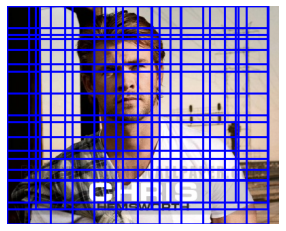

In [8]:
data_dir='./'
face_detection_dir = os.path.join(data_dir, 'face_detection')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

val_data, val_bboxes = load_validation_data(validation_faces_dir)

image = val_data[100]
gray_image = extract_features(FeatureExtractors.CNN, image)

window_size = (128, 128)
stride = 32

patches, bbox_locations = [], []
patches, bbox_locations = sliding_window(gray_image, window_size, 1, stride)
show_image_with_bbox(image, bbox_locations,
                     [0, 0, window_size[0], window_size[1]],
                     draw_GT=True)

# Entrenamiento del Modelo

## Carga de datos de entrenamiento

#### Ubicacion de los datos

In [7]:
data_dir='./'
face_detection_dir = os.path.join(data_dir, 'face_detection')
training_faces_dir = os.path.join(face_detection_dir,'cropped_faces')
negative_examples_training_dir = os.path.join(face_detection_dir,'negative_data')
validation_faces_dir = os.path.join(face_detection_dir,'validation')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

#### Load Training Data

In [9]:
training_data, training_labels = load_training_data(training_faces_dir,
                                                   negative_examples_training_dir,
                                                   FeatureExtractors.CNN)

  1%|          | 55/9914 [00:00<00:18, 539.57it/s]

##Loading 9914 positive face images


  1%|          | 65/7489 [00:00<00:11, 640.50it/s]

##Loading 7489 negative face images


100%|██████████| 7489/7489 [00:12<00:00, 586.45it/s]


#### Load Validation Data

In [10]:
validation_data = load_validation_data(validation_faces_dir)

 23%|██▎       | 41/175 [00:00<00:00, 401.60it/s]

(175, 6)


100%|██████████| 175/175 [00:00<00:00, 422.32it/s]


#### Entrenar el clasificador SVM de sklearn

In [ ]:
svm_classifier = svm.SVC(kernel='linear',
                         probability=True)

In [ ]:
svm_classifier.fit(training_data, training_labels)

## Keras CNN

In [62]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=(128, 128, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 activation_40 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 activation_41 (Activation)  (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                 

In [53]:
x_train, x_test, y_train, y_test = train_test_split(training_data,
                                                    training_labels,
                                                    test_size=0.33,
                                                    random_state=7)

In [63]:
history = model.fit(x_train, y_train,
                    epochs=120,
                    batch_size=16,
                    validation_data=(x_test, y_test))

Epoch 1/120
729/729 [==============================] - 76s 103ms/step - loss: 0.2230 - accuracy: 0.9159 - val_loss: 0.0832 - val_accuracy: 0.9751
Epoch 2/120
729/729 [==============================] - 73s 100ms/step - loss: 0.1249 - accuracy: 0.9672 - val_loss: 0.1521 - val_accuracy: 0.9761
Epoch 3/120
729/729 [==============================] - 72s 99ms/step - loss: 0.1213 - accuracy: 0.9713 - val_loss: 0.0945 - val_accuracy: 0.9784
Epoch 4/120
729/729 [==============================] - 76s 104ms/step - loss: 0.1202 - accuracy: 0.9716 - val_loss: 0.1030 - val_accuracy: 0.9781
Epoch 5/120
729/729 [==============================] - 77s 106ms/step - loss: 0.1263 - accuracy: 0.9714 - val_loss: 0.1117 - val_accuracy: 0.9742
Epoch 6/120
729/729 [==============================] - 76s 104ms/step - loss: 0.1084 - accuracy: 0.9748 - val_loss: 0.1148 - val_accuracy: 0.9694
Epoch 7/120
729/729 [==============================] - 75s 104ms/step - loss: 0.1174 - accuracy: 0.9734 - val_loss: 0.1764 - 

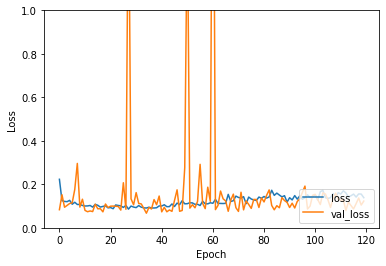

In [64]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

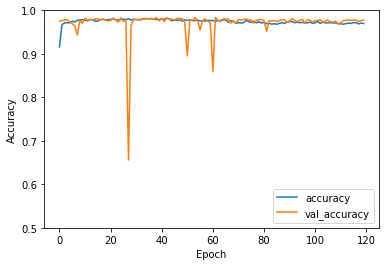

In [65]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [66]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('test_acc', test_acc)
print('test_loss', test_loss)

180/180 - 7s - loss: 0.1229 - accuracy: 0.9774 - 7s/epoch - 39ms/step
test_acc 0.9773637652397156
test_loss 0.12289398163557053


#### Save trained model

In [ ]:
#svm
pickle.dump(svm_classifier, open('./face_detector', 'wb'))

In [67]:
#cnn
model.save('face_detector_dropouts.h5')

#### Load trained model

In [ ]:
# svm
classifier = pickle.load(open('./face_detector','rb'))

In [47]:
#cnn
classifier = keras.models.load_model('face_detector_dropouts.h5')

In [ ]:
## RELOAD MODEL
model = keras.models.load_model('face_detector_2hidden.h5')
#model.summary()

## Sliding Window & Results

 11%|█▏        | 20/175 [00:00<00:00, 199.46it/s]

(175, 6)


100%|██████████| 175/175 [00:00<00:00, 328.23it/s]


i:  96 t:  118
8/8 [==============================] - 0s 38ms/step


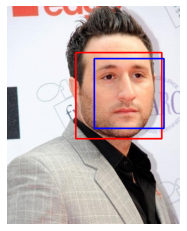

i:  76 t:  86
8/8 [==============================] - 0s 37ms/step


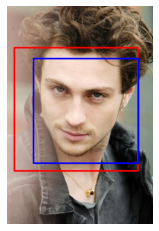

i:  128 t:  158
8/8 [==============================] - 0s 41ms/step


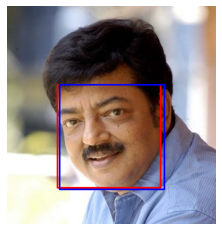

i:  21 t:  26
8/8 [==============================] - 0s 40ms/step


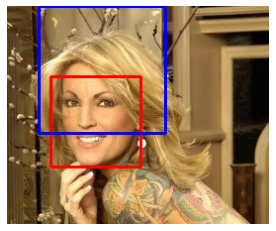

i:  166 t:  160
8/8 [==============================] - 0s 37ms/step


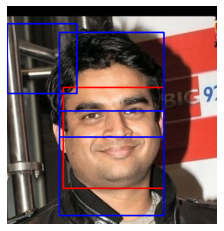

i:  76 t:  94
8/8 [==============================] - 0s 37ms/step


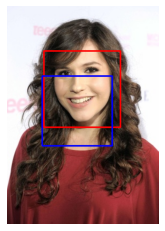

i:  102 t:  107
8/8 [==============================] - 0s 41ms/step


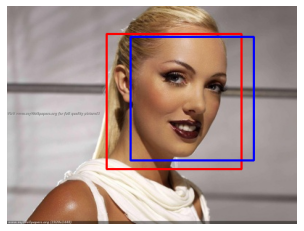

i:  76 t:  88
8/8 [==============================] - 0s 39ms/step


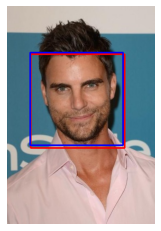

i:  76 t:  86
8/8 [==============================] - 0s 39ms/step


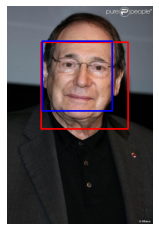

i:  90 t:  103
8/8 [==============================] - 0s 39ms/step


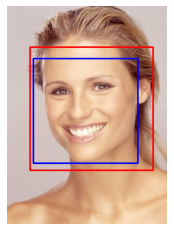

i:  108 t:  119
8/8 [==============================] - 0s 44ms/step


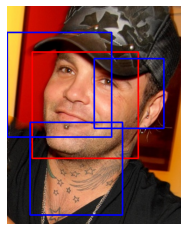

i:  76 t:  87
8/8 [==============================] - 0s 38ms/step


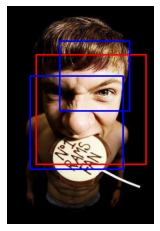

i:  128 t:  142
8/8 [==============================] - 0s 41ms/step


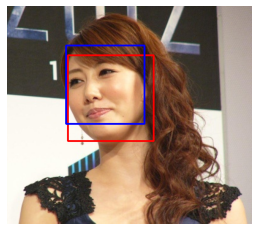

i:  95 t:  101
8/8 [==============================] - 0s 43ms/step


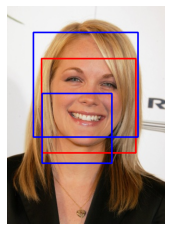

i:  128 t:  156
8/8 [==============================] - 0s 41ms/step


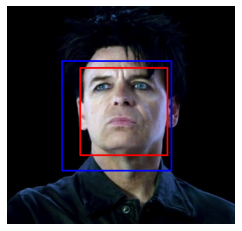

In [35]:
'''
Afinar parametros:
    threshold_p
    overlap_threshold
    non_max_threshold
'''

non_max_threshold = 0.8
window_size = (128, 128)
scale = 1
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
sample_images = 15
stride = 32
for img, gt_bbox in zip(validation_data[:sample_images],validation_bboxes[:sample_images]):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.CNN, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    
    ## Get prediction label for each sliding window patch
    if patches_feature_representation.shape[0] > 0:
        scores = classifier.predict(patches_feature_representation)
        face_probabilities = scores[:,0]
        face_bboxes = bbox_locations[face_probabilities>threshold_p]
        face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
        
        # Do non max suppression and select strongest probability box
        [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites,0.3)
    else:
        selected_bbox = []
    show_image_with_bbox(img, selected_bbox,gt_bbox)

## Evaluate Detector

In [58]:
total_true_positives = []
total_real_positives = []
total_positive_predictions = []
window_size = [128, 128]
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
k = 0
stride = 8
scale = 1
for img, gt_bbox in zip(validation_data,validation_bboxes):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.CNN, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    ## Get score for each sliding window patch
    scores = classifier.predict(patches_feature_representation)  
    #print(scores)
    ## Positive Face Probabilities
    face_probabilities = scores[:,0]
    ## liblinbear prediction
    #[labels, acc, prob] = predict([],patches_feature_representation, clasifier)
    #face_probabilities = np.asarray(prob)
    #face_probabilities = face_probabilities.T[0]

    [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities);
    total_true_positives.append(detected_true_positives)
    total_real_positives.append(image_real_positives)
    total_positive_predictions.append(detected_faces)
        
total_true_positives = np.asarray(total_true_positives)
total_real_positives = np.asarray(total_real_positives)
total_positive_predictions = np.asarray(total_positive_predictions)

 37%|███▋      | 64/175 [00:00<00:00, 314.19it/s]

(175, 6)


100%|██████████| 175/175 [00:00<00:00, 320.91it/s]


i:  250 t:  1454
8/8 [==============================] - 0s 41ms/step
i:  250 t:  1016
8/8 [==============================] - 0s 40ms/step
i:  250 t:  2014
8/8 [==============================] - 0s 44ms/step
i:  250 t:  280
8/8 [==============================] - 0s 45ms/step
i:  250 t:  2042
8/8 [==============================] - 0s 42ms/step
i:  250 t:  1109
8/8 [==============================] - 0s 41ms/step
i:  250 t:  1301
8/8 [==============================] - 0s 43ms/step
i:  250 t:  1047
8/8 [==============================] - 0s 43ms/step
i:  250 t:  1016
8/8 [==============================] - 0s 42ms/step
i:  250 t:  1248
8/8 [==============================] - 0s 45ms/step
i:  250 t:  1474
8/8 [==============================] - 0s 42ms/step
i:  250 t:  1029
8/8 [==============================] - 0s 41ms/step
i:  250 t:  1783
8/8 [==============================] - 0s 43ms/step
i:  250 t:  1212
8/8 [==============================] - 0s 47ms/step
i:  250 t:  2005
8/8 [=============

In [59]:
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_positive_predictions)

(0.0, 1.1)

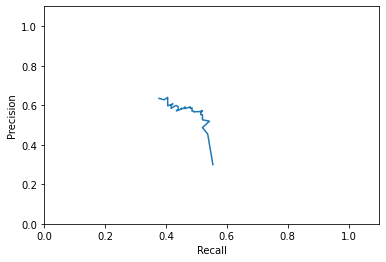

In [60]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

In [61]:
ap = interpolated_average_precision(recall,precision)
print('Detection Average Precision is {}'.format(ap))

Detection Average Precision is [0.24137907]


### Implementacion SVM:

### Implementacion CNN: